In [1]:
import numpy as np
import openturns as ot
from depimpact import ConservativeEstimate
from dependence import quantile_func
import dask
from depimpact.utils import get_grid_sample
from depimpact.tests.test_functions import func_cum_sum_weight, func_spec
from dependence import iterative_vine_minimize
from depimpact.dependence_plot import set_style_paper

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
dim = 3
margins = [ot.Uniform(-i + (-1)**i, i+1 + (-1)**(i+1)) for i in range(1, dim+1)]
families = np.tril(np.ones((dim, dim)), k=-1)
#test_func = lambda x: func_cum_sum_weight(x, use_sum=False)
test_func = lambda x: func_spec(x)

quant_estimate = ConservativeEstimate(test_func, margins, families)

In [3]:
K = 1000
n = 50000
alpha = 0.05
q_func = quantile_func(alpha)

algorithm_parameters = {
    "n_input_sample": n,
    "n_dep_param_init": 100,
    "max_n_pairs": 2,
    "grid_type": 'lhs',
    "q_func": q_func,
    "n_add_pairs": 1,
    "n_remove_pairs": 0,
    "adapt_vine_structure": True,
    "with_bootstrap": False,
    "verbose": True,
    "iterative_save": False,
    "iterative_load": False,
    "load_input_samples": False,
    "keep_input_samples": False
}

In [4]:
grid_result_lhs = quant_estimate.gridsearch(K, n, q_func=q_func, grid_type='lhs', keep_input_samples=False)
print('Min quantile: {0}\nMin Kendall: {1}'.format(grid_result_lhs.min_result.quantity, grid_result_lhs.min_result.kendall_tau))

Min quantile: -19.5006602448
Min Kendall: [-0.9632699999999994, -0.31976999999999994, -0.4860900000000001]


In [5]:
grid_result_vertices = quant_estimate.gridsearch(K, n, q_func=q_func, grid_type='vertices', keep_input_samples=False)
print('Min quantile: {0}\nMin Kendall: {1}'.format(grid_result_vertices.min_result.quantity, grid_result_vertices.min_result.kendall_tau))

Min quantile: -17.9875166123
Min Kendall: [0.0, 0.0, 0.0]


In [6]:
iterative_results = iterative_vine_minimize(estimate_object=quant_estimate, **algorithm_parameters)

n=50000. Worst quantile of [(1, 0)] at -18.1627130921
n=50000. Worst quantile of [(2, 0)] at -18.3430990454
n=50000. Worst quantile of [(2, 1)] at -18.571560749

Iteration 1: selected pair: (2, 1)
Total number of evaluations = 15000000. Minimum quantity at -18.57.

n=50000. Worst quantile of [(2, 1), (1, 0)] at -18.6849116486
n=50000. Worst quantile of [(2, 1), (2, 0)] at -18.7313588589

Iteration 2: selected pair: (2, 0)
Total number of evaluations = 25000000. Minimum quantity at -18.73.

Max number of pairs reached


In [7]:
indep_result = quant_estimate.independence(n, q_func=q_func, keep_input_sample=False)
print('Min quantile: {0} at independence'.format(indep_result.quantity))

Min quantile: -18.1739882805 at independence


In [8]:
kendalls_lhs = grid_result_lhs.kendalls
kendalls_vertices = grid_result_vertices.kendalls
dev_kendall_lhs = abs(kendalls_lhs).mean(axis=1)
dev_kendall_vertices = abs(kendalls_vertices).mean(axis=1)
quantities_lhs = grid_result_lhs.quantities
quantities_vertices = grid_result_vertices.quantities
quantity_indep = indep_result.quantity

In [9]:
min_kendall_lhs = grid_result_lhs.min_result.kendall_tau
min_kendall_vertices = grid_result_vertices.min_result.kendall_tau
min_dev_kendall_lhs = np.abs(min_kendall_lhs).mean()
min_dev_kendall_vertices = np.abs(min_kendall_vertices).mean()
min_quantity_lhs = grid_result_lhs.min_result.quantity
min_quantity_vertices = grid_result_vertices.min_result.quantity

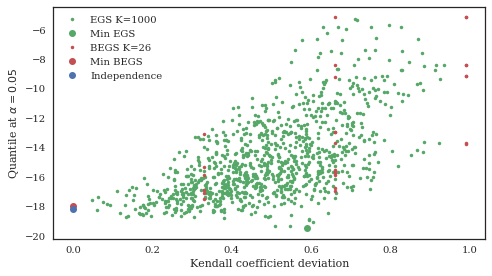

In [10]:
set_style_paper()
fig, ax = plt.subplots(figsize=(7, 4))    
ax.plot(dev_kendall_lhs, quantities_lhs, 'g.', label='EGS K=%d' % (K))
ax.plot(min_dev_kendall_lhs, min_quantity_lhs, 'go', label='Min EGS')
ax.plot(dev_kendall_vertices, quantities_vertices, 'r.', label='BEGS K=%d' % (min(K, 3**dim-1)))
ax.plot(min_dev_kendall_vertices, min_quantity_vertices, 'ro', label='Min BEGS')
ax.plot(0., quantity_indep, 'bo', label='Independence')
ax.legend(loc=0)
ax.set_xlabel('Kendall coefficient deviation')
ax.set_ylabel('Quantile at $\\alpha = %.2f$' % (alpha))
fig.tight_layout()
fig.savefig('./output/non_monotonic_multidim_test_quantile_dim_%d_K_%d.pdf' % (dim, K))
fig.savefig('./output/non_monotonic_multidim_test_quantile_dim_%d_K_%d.png' % (dim, K))

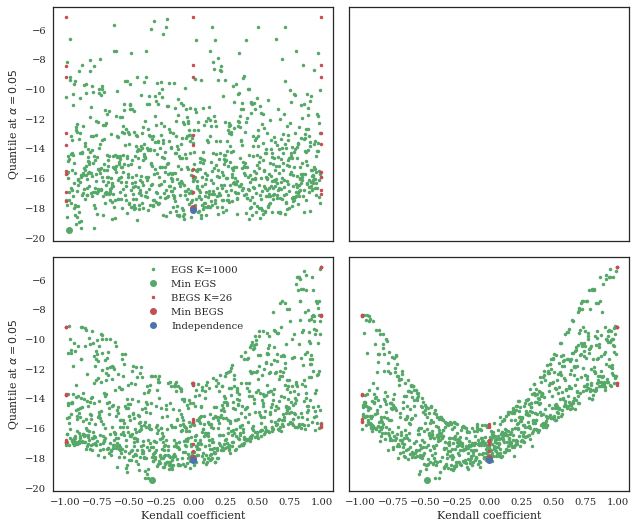

In [11]:
fig, axes = plt.subplots(dim-1, dim-1, figsize=(3*dim, 2.5*dim), sharex=True, sharey=True)

k = 0
for i in range(dim-1):
    for j in range(i+1):
        ax = axes[i, j]
        ax.plot(kendalls_lhs[:, k], quantities_lhs, 'g.', label='EGS K=%d' % (K))
        ax.plot(min_kendall_lhs[k], min_quantity_lhs, 'go', label='Min EGS')
        ax.plot(kendalls_vertices[:, k], quantities_vertices, 'r.', label='BEGS K=%d' % (min(K, 3**dim-1)))
        ax.plot(min_kendall_vertices[k], min_quantity_vertices, 'ro', label='Min BEGS')
        ax.plot(0., quantity_indep, 'bo', label='Independence')
        k += 1
        if i == dim-2:
            ax.set_xlabel('Kendall coefficient')
        if j == 0:
            ax.set_ylabel('Quantile at $\\alpha = %.2f$' % (alpha))
        if i == j+1:
            ax.legend(loc=0)
            
fig.tight_layout()
fig.savefig('./output/matrix_plot_non_monotonic_multidim_test_quantile_dim_%d_K_%d.pdf' % (dim, K))
fig.savefig('./output/matrix_plot_non_monotonic_multidim_test_quantile_dim_%d_K_%d.png' % (dim, K))

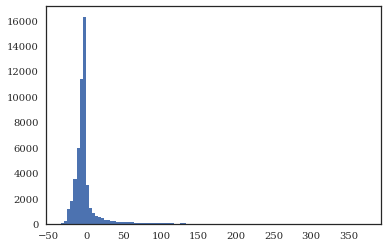

In [12]:
plt.hist(indep_result.output_sample, bins=100);

In [13]:
plt.hist(grid_result.min_result.output_sample, bins=100);

NameError: name 'grid_result' is not defined